In [3]:
# fix python path if working locally
# from utils import fix_pythonpath_if_working_locally

# fix_pythonpath_if_working_locally()

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)
from darts.metrics import mape, smape, mae, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset, ElectricityDataset

import logging

logging.disable(logging.CRITICAL)

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

In [4]:
df1 = pd.read_csv('archive/TripA01.csv', sep=';', encoding="unicode_escape")
df2 = pd.read_csv('archive/TripA02.csv', sep=';', encoding="unicode_escape")
# df3 = pd.read_csv('archive/TripA03.csv', sep=';', encoding="unicode_escape")
# df4 = pd.read_csv('archive/TripA04.csv', sep=';', encoding="unicode_escape")

In [ ]:
def preprocess(df, target=None, covariates=None):
    '''This function takes in dataframe and returns a target time series and a covartiate time series'''
    import pandas as pd
    from darts import Timeseries
    from darts.dataprocessing.transformers import Scaler
    
    df.set_index("Time [s]", inplace=False)

    start_time = '2020-01-01'  # Example start date - Will update later when dataset is correctly made.

    df.index = pd.date_range(start=start_time, periods=len(df), freq='S')

    ts=[]
    if covariate_ts='all':
        for column in df.columns:
            ts[column] = TimeSeries.from_dataframe(df, value_cols=column)
    else:
        for column in covariates:
            ts[column] = TimeSeries.from_dataframe(df, value_cols=column)

    scaler = Scaler()

    for timeseries in ts:
        covar_ts.stack(timeseries)

    covar_ts = scaler.fit_transform(covar_ts)
    target_ts = scaler.fit_transform(target_ts)

    
    return target_ts, covariates

In [ ]:
ts_full = [preprocess(df) for df in os.walk('archive/*.csv')]

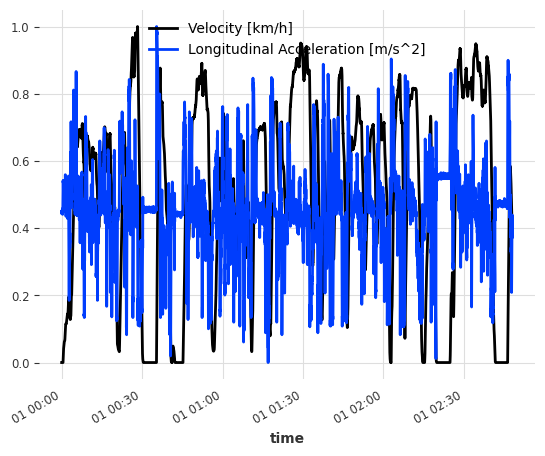

In [5]:
df1.set_index("Time [s]", inplace=False)
df2.set_index("Time [s]", inplace=False)

start_time = '2020-01-01'  # Example start date
df1.index = pd.date_range(start=start_time, periods=len(df1), freq='S')
df2.index = pd.date_range(start=start_time, periods=len(df2), freq='S')

df1.index.freq = 'S'
df2.index.freq = 'S'

velo_ts1 = TimeSeries.from_dataframe(df1, value_cols='Velocity [km/h]')
accel_ts1 = TimeSeries.from_dataframe(df1, value_cols='Longitudinal Acceleration [m/s^2]')
soc_ts1 = TimeSeries.from_dataframe(df1, value_cols='SoC [%]')

velo_ts2 = TimeSeries.from_dataframe(df2, value_cols='Velocity [km/h]')
accel_ts2 = TimeSeries.from_dataframe(df2, value_cols='Longitudinal Acceleration [m/s^2]')
soc_ts2 = TimeSeries.from_dataframe(df2, value_cols='SoC [%]')

batt_covar1 = velo_ts1.stack(accel_ts1)
batt_covar2 = velo_ts2.stack(accel_ts2)

scaler = Scaler()
batt_covar1 = scaler.fit_transform(batt_covar1)
batt_covar2 = scaler.fit_transform(batt_covar2)
batt_covar1.plot()

soc_ts1 = scaler.fit_transform(soc_ts1)
soc_ts2 = scaler.fit_transform(soc_ts2)

In [20]:
splitter1 = int(len(soc_ts1)*0.7)
soc_train1, soc_valid1 = soc_ts1[:splitter1], soc_ts1[splitter1:]
batt_covar_train1, batt_covar_valid1 = batt_covar1[:splitter1], batt_covar1[splitter1:]

splitter2 = int(len(soc_ts2)*0.7)
soc_train2, soc_valid2 = soc_ts2[:splitter2], soc_ts2[splitter2:]
batt_covar_train2, batt_covar_valid2 = batt_covar2[:splitter2], batt_covar2[splitter2:]

In [32]:
pred_len=len(soc_valid2)

In [27]:
model_pastcov = BlockRNNModel(
    model="LSTM",
    input_chunk_length=600,
    output_chunk_length=100,
    n_epochs=10,
    random_state=0,
)

In [28]:
model_pastcov.fit(
    series=[soc_train1, soc_train2],
    past_covariates=[batt_covar_train1, batt_covar_train2],
    verbose=True,
)

Training: |                                                                                      | 0/? [00:00<…

BlockRNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=1, hidden_fc_sizes=None, dropout=0.0, input_chunk_length=600, output_chunk_length=100, n_epochs=10, random_state=0)

Predicting: |                                                                                    | 0/? [00:00<…

RMSE = 0.15%


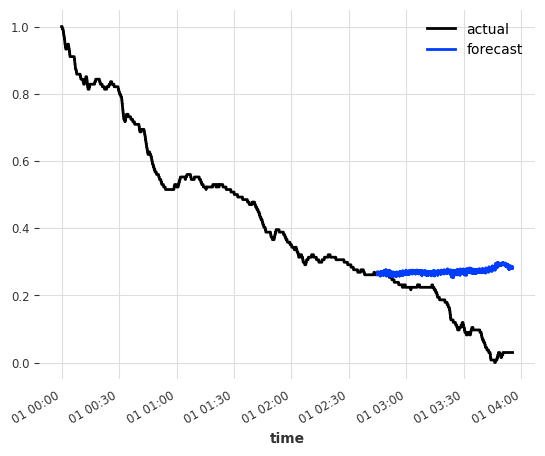

In [36]:
pred_cov = model_pastcov.predict(n=pred_len, series=soc_train2, past_covariates=batt_covar2)

soc_ts2.plot(label="actual")
pred_cov.plot(label="forecast")
plt.legend()
print("RMSE = {:.2f}%".format(rmse(soc_ts2[splitter2:], pred_cov)))

<Axes: xlabel='time'>

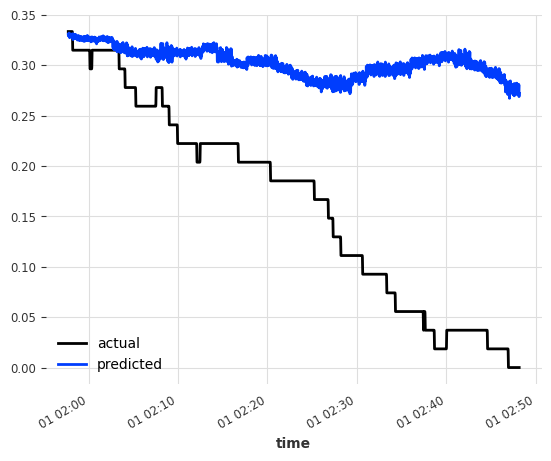

In [30]:
soc_ts1[splitter1:].plot(label="actual")
pred_cov.plot(label="predicted")